In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import jax.numpy as jnp
import numpy as onp
from reusable.util import (
    load_args,
    load_training_history,
    load_scores,
    gen_file_name,
    get_decoder_params,
    load_training_state,
)
import matplotlib.pyplot as plt
from plotting.plots import plot_training, plot_draws_hpdi
import jax.random as random
from reusable.vae import VAE, vae_sample
from reusable.train_nn import SimpleTrainState
import optax
from numpyro.infer import Predictive
from reusable.gp import BuildGP
import pandas
from plotting.paper import align_left_backfill, align_right_backfill, calc_plot_dimensions, clear_unused_axs, align_right_backfill_with_gp, pretty_loss_fn_name


# Experiments for different loss functions

In [ ]:
def plot_training_histories(code, exp_name, args_count, num_cols=None, num_rows=None, backfill=None):
    args = load_args(str(code), args_count, exp_name)

    twoD, num_rows, num_cols = calc_plot_dimensions(args, num_cols, num_rows, False, False)

    match backfill:
        case None:
            mapping = lambda i: i
        case "align_left":
            mapping = align_left_backfill(len(args["loss_fns"]), num_rows, num_cols)
        case "align_right":
            mapping = align_right_backfill(len(args["loss_fns"]), num_rows, num_cols)

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 6, num_rows * 5))

    clear_unused_axs(axs, mapping, twoD, len(args["loss_fn_names"]))

    for i, loss_fn in enumerate(args["loss_fn_names"]):

        hist = load_training_history(code, gen_file_name(code, args, args["experiment"] + loss_fn))
        plot_training(
            hist["test_loss"],
            hist["train_loss"],
            pretty_loss_fn_name(loss_fn),
            ax=axs[onp.unravel_index(mapping(i), (num_rows, num_cols)) if twoD else i],
        )

    fig.tight_layout()
    
    fig.savefig(f"./gen_plots/{code}/{code}_{exp_name}_{args_count}_training.png")


In [ ]:
def plot_trained_draws(code, exp_name, args_count, num_cols=None, num_rows=None, backfill=None, separate_gp=False, leakyvae=False):
    rng_key = random.PRNGKey(3)
    rng_key, rng_key_gp = random.split(rng_key, 2)

    args = load_args(str(code), str(args_count), exp_name)

    twoD, num_rows, num_cols = calc_plot_dimensions(args, num_cols, num_rows, True, separate_gp)

    match backfill:
        case None:
            if separate_gp:
                mapping = lambda i: 0 if i == 0 else i - 1 + num_cols
            else:
                mapping = lambda i: i
        case "align_left":
            mapping = align_left_backfill(len(args["loss_fns"]) + 1, num_rows, num_cols)
        case "align_right":
            mapping = align_right_backfill_with_gp(len(args["loss_fns"]) + 1, num_rows, num_cols)

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 6, num_rows * 5))

    clear_unused_axs(axs, mapping, twoD, len(args["loss_fn_names"]) + 1)

    gp = BuildGP(
        args["gp_kernel"],
        noise=False,
        length_prior_choice=args["length_prior_choice"],
        prior_args=args["length_prior_arguments"],
    )

    plot_gp_predictive = Predictive(gp, num_samples=5000)

    gp_draws = plot_gp_predictive(rng_key_gp, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5)["y"]
    plot_draws_hpdi(
        gp_draws,
        args["x"],
        f"GP draws",
        "$y=f_{GP}(x)$",
        "GP",
        ax=axs[onp.unravel_index(mapping(0), (num_rows, num_cols)) if twoD else 0],
    )

    for i, loss_fn in enumerate(args["loss_fn_names"]):
        rng_key, rng_key_init, rng_key_predict = random.split(rng_key, 3)

        module = VAE(
            hidden_dim1=args["hidden_dim1"],
            hidden_dim2=args["hidden_dim2"],
            latent_dim=args["latent_dim"],
            out_dim=args["n"],
            conditional=False,
            leaky=False
        )
        params = module.init(rng_key, jnp.ones((args["n"],)))["params"]
        tx = optax.adam(args["learning_rate"])
        state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key=rng_key_init)

        decoder_params = get_decoder_params(
            load_training_state(code, gen_file_name(code, args, args["experiment"] + loss_fn), state)
            
        )

        plot_vae_predictive = Predictive(vae_sample, num_samples=5000)
        vae_draws = plot_vae_predictive(
            rng_key_predict,
            hidden_dim1=args["hidden_dim1"],
            hidden_dim2=args["hidden_dim2"],
            latent_dim=args["latent_dim"],
            out_dim=args["n"],
            decoder_params=decoder_params,
        )["f"]
        plot_draws_hpdi(
            vae_draws,
            args["x"],
            pretty_loss_fn_name(loss_fn),
            "$y=f_{VAE}(x)$",
            "PriorVAE",
            ax=axs[onp.unravel_index(mapping(i + 1), (num_rows, num_cols)) if twoD else i + 1],
        )

    fig.tight_layout()

    fig.savefig(f"./gen_plots/{code}/{code}_{exp_name}_{args_count}_draws.png")


In [ ]:
def merge_dicts(a: dict, b: dict):
    for key, val in b.items():
        if len(val) > 0 and isinstance(val[0], str):
            if key not in a:
                a[key] = [val]
            else:
                a[key] = a[key] + [val]
        else:
            if key not in a:
                a[key] = jnp.array(val)[None]
            else:
                a[key] = jnp.concatenate((a[key], jnp.array(val)[None]), axis=0)


def get_loss_scores(code: int, exp_name, args_count: int):
    """Given the raw data (which is v. oddly formatted), return a dictionary of lists:
    - loss_fns
    - frobenius: items: array of length num_orders_calced
    - vae_moments: 2d array: (num_orders, n)
    - mmd: items: array of values for each kernel choice
    - mmd_kernels: list of string names
    """
    args = load_args(str(code), str(args_count), exp_name)

    scores = {"loss_fns": []}
    for i, loss_fn in enumerate(args["loss_fn_names"]):
        scores["loss_fns"].append(loss_fn)
        s = load_scores(
            args["expcode"],
            gen_file_name(code, args, args["experiment"] + loss_fn),
        )
        s["mmd_kernels"] = [x[0] for x in s["mmd"]]
        s["mmd"] = [x[1] for x in s["mmd"]]
        merge_dicts(scores, s)

    return scores




def show_loss_scores(code, exp_name, args_count):

    scores = get_loss_scores(code, exp_name, args_count)

    scores["avg_vae_moments"] = scores["vae_moments"].mean(axis=-1)

    to_plot = ["frobenius", "mmd"]  # "avg_vae_moments",
    std_range = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    col_labels = ["Moment", "MMD kernel"]
    pretty_labels = [std_range, [pretty_loss_fn_name(x) for x in scores["mmd_kernels"][0]]]
    labels = [std_range, scores["mmd_kernels"][0]]

    for p, l, c in zip(to_plot, labels, col_labels):
        df = pandas.DataFrame(
            scores[p],
            columns=pandas.Index(l, name=c),
            index=pandas.Index([pretty_loss_fn_name(x) for x in scores["loss_fns"]], name="Loss functions"),
        )

        s = df.style.highlight_min(axis=0, props="bfseries: ;")

        with open(f"./gen_plots/{code}/{code}_{exp_name}_{args_count}_{p}_table.tex", "w") as f:
            s.to_latex(f)

        with open(f"./gen_plots/{code}/{code}_{exp_name}_{args_count}_{p}_table.str", "w") as f:
            df.to_string(f)

        df = pandas.DataFrame(
            scores[p], columns=pandas.Index(l, name=c), index=pandas.Index(scores["loss_fns"], name="Loss functions")
        )

        s = df.style.highlight_min(axis=0, props="font-weight:bold;")
        display(s)

    pass


In [ ]:
experiment = "exp1"
number = "1" # disambiguate argument files

show_loss_scores(16, experiment, number)

plot_training_histories(16, experiment, number, num_cols=4, num_rows=3, backfill="align_right")
plot_trained_draws(16, experiment, number, num_cols=4, num_rows=3, backfill="align_right")

In [ ]:
experiment = "exp2"
number = "1" # disambiguate argument files

show_loss_scores(16, experiment, number)
plot_training_histories(16, experiment, number, backfill="align_right")
plot_trained_draws(16, experiment, number,  backfill="align_right")

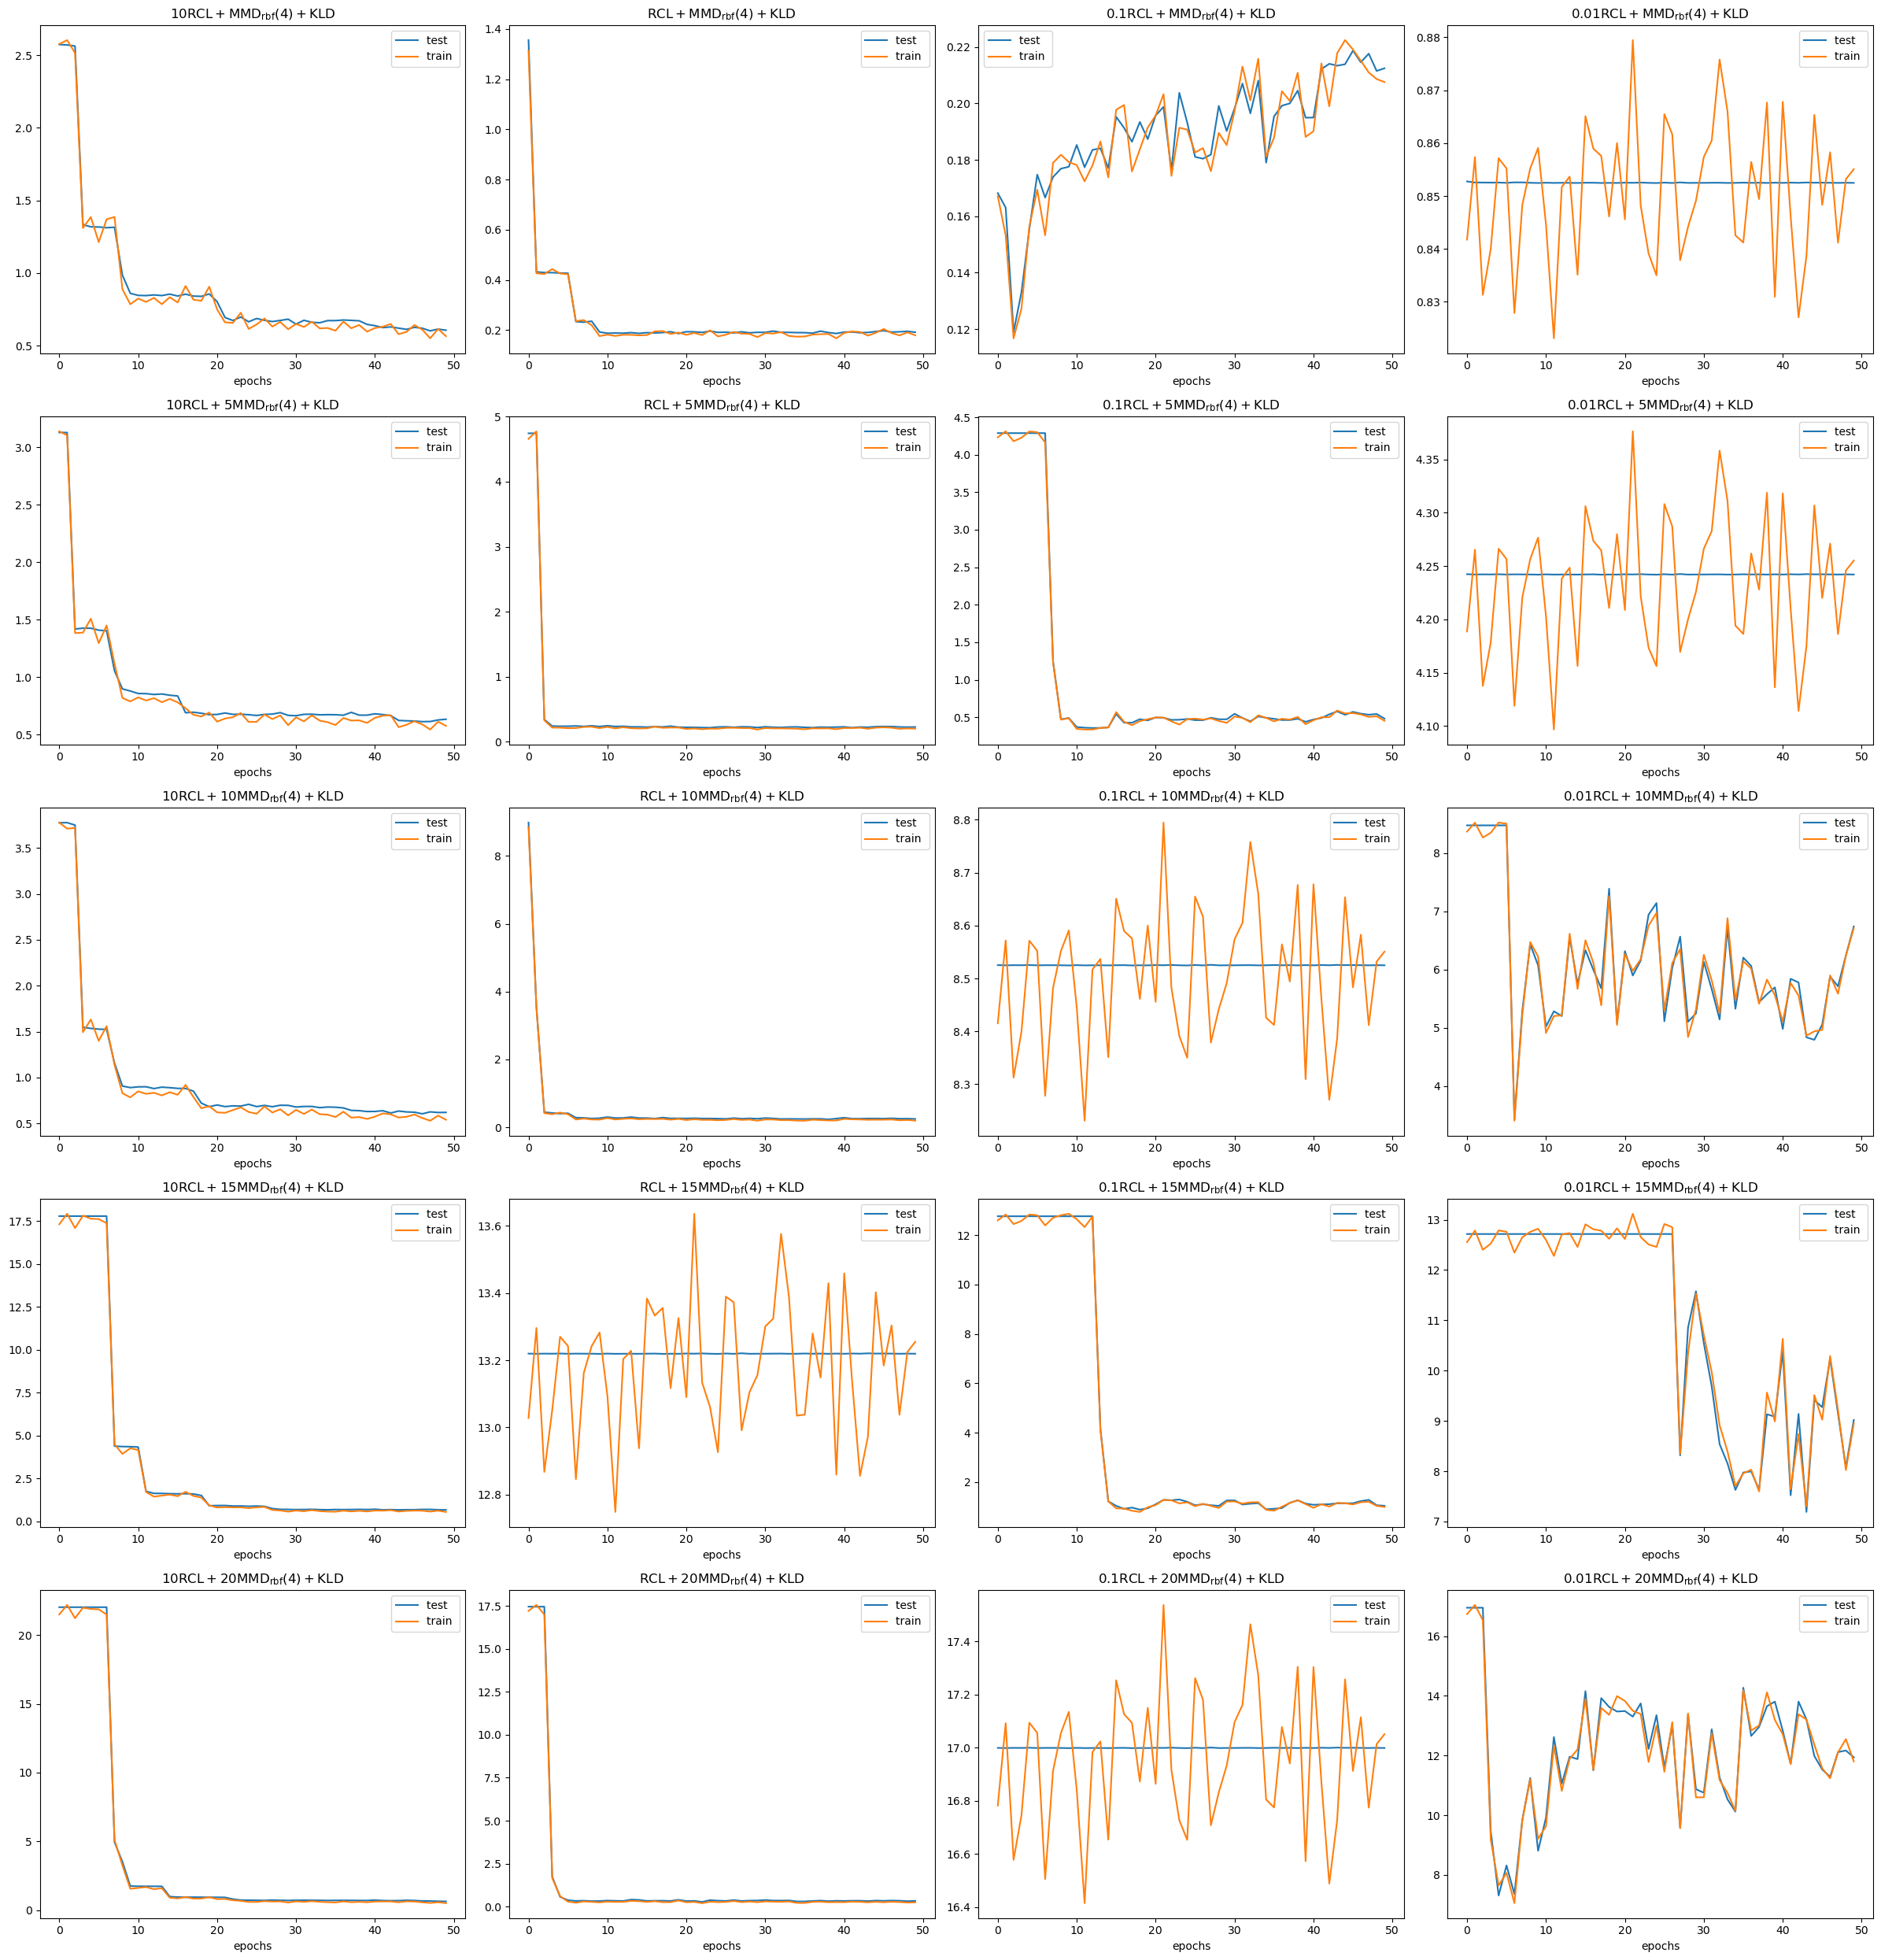

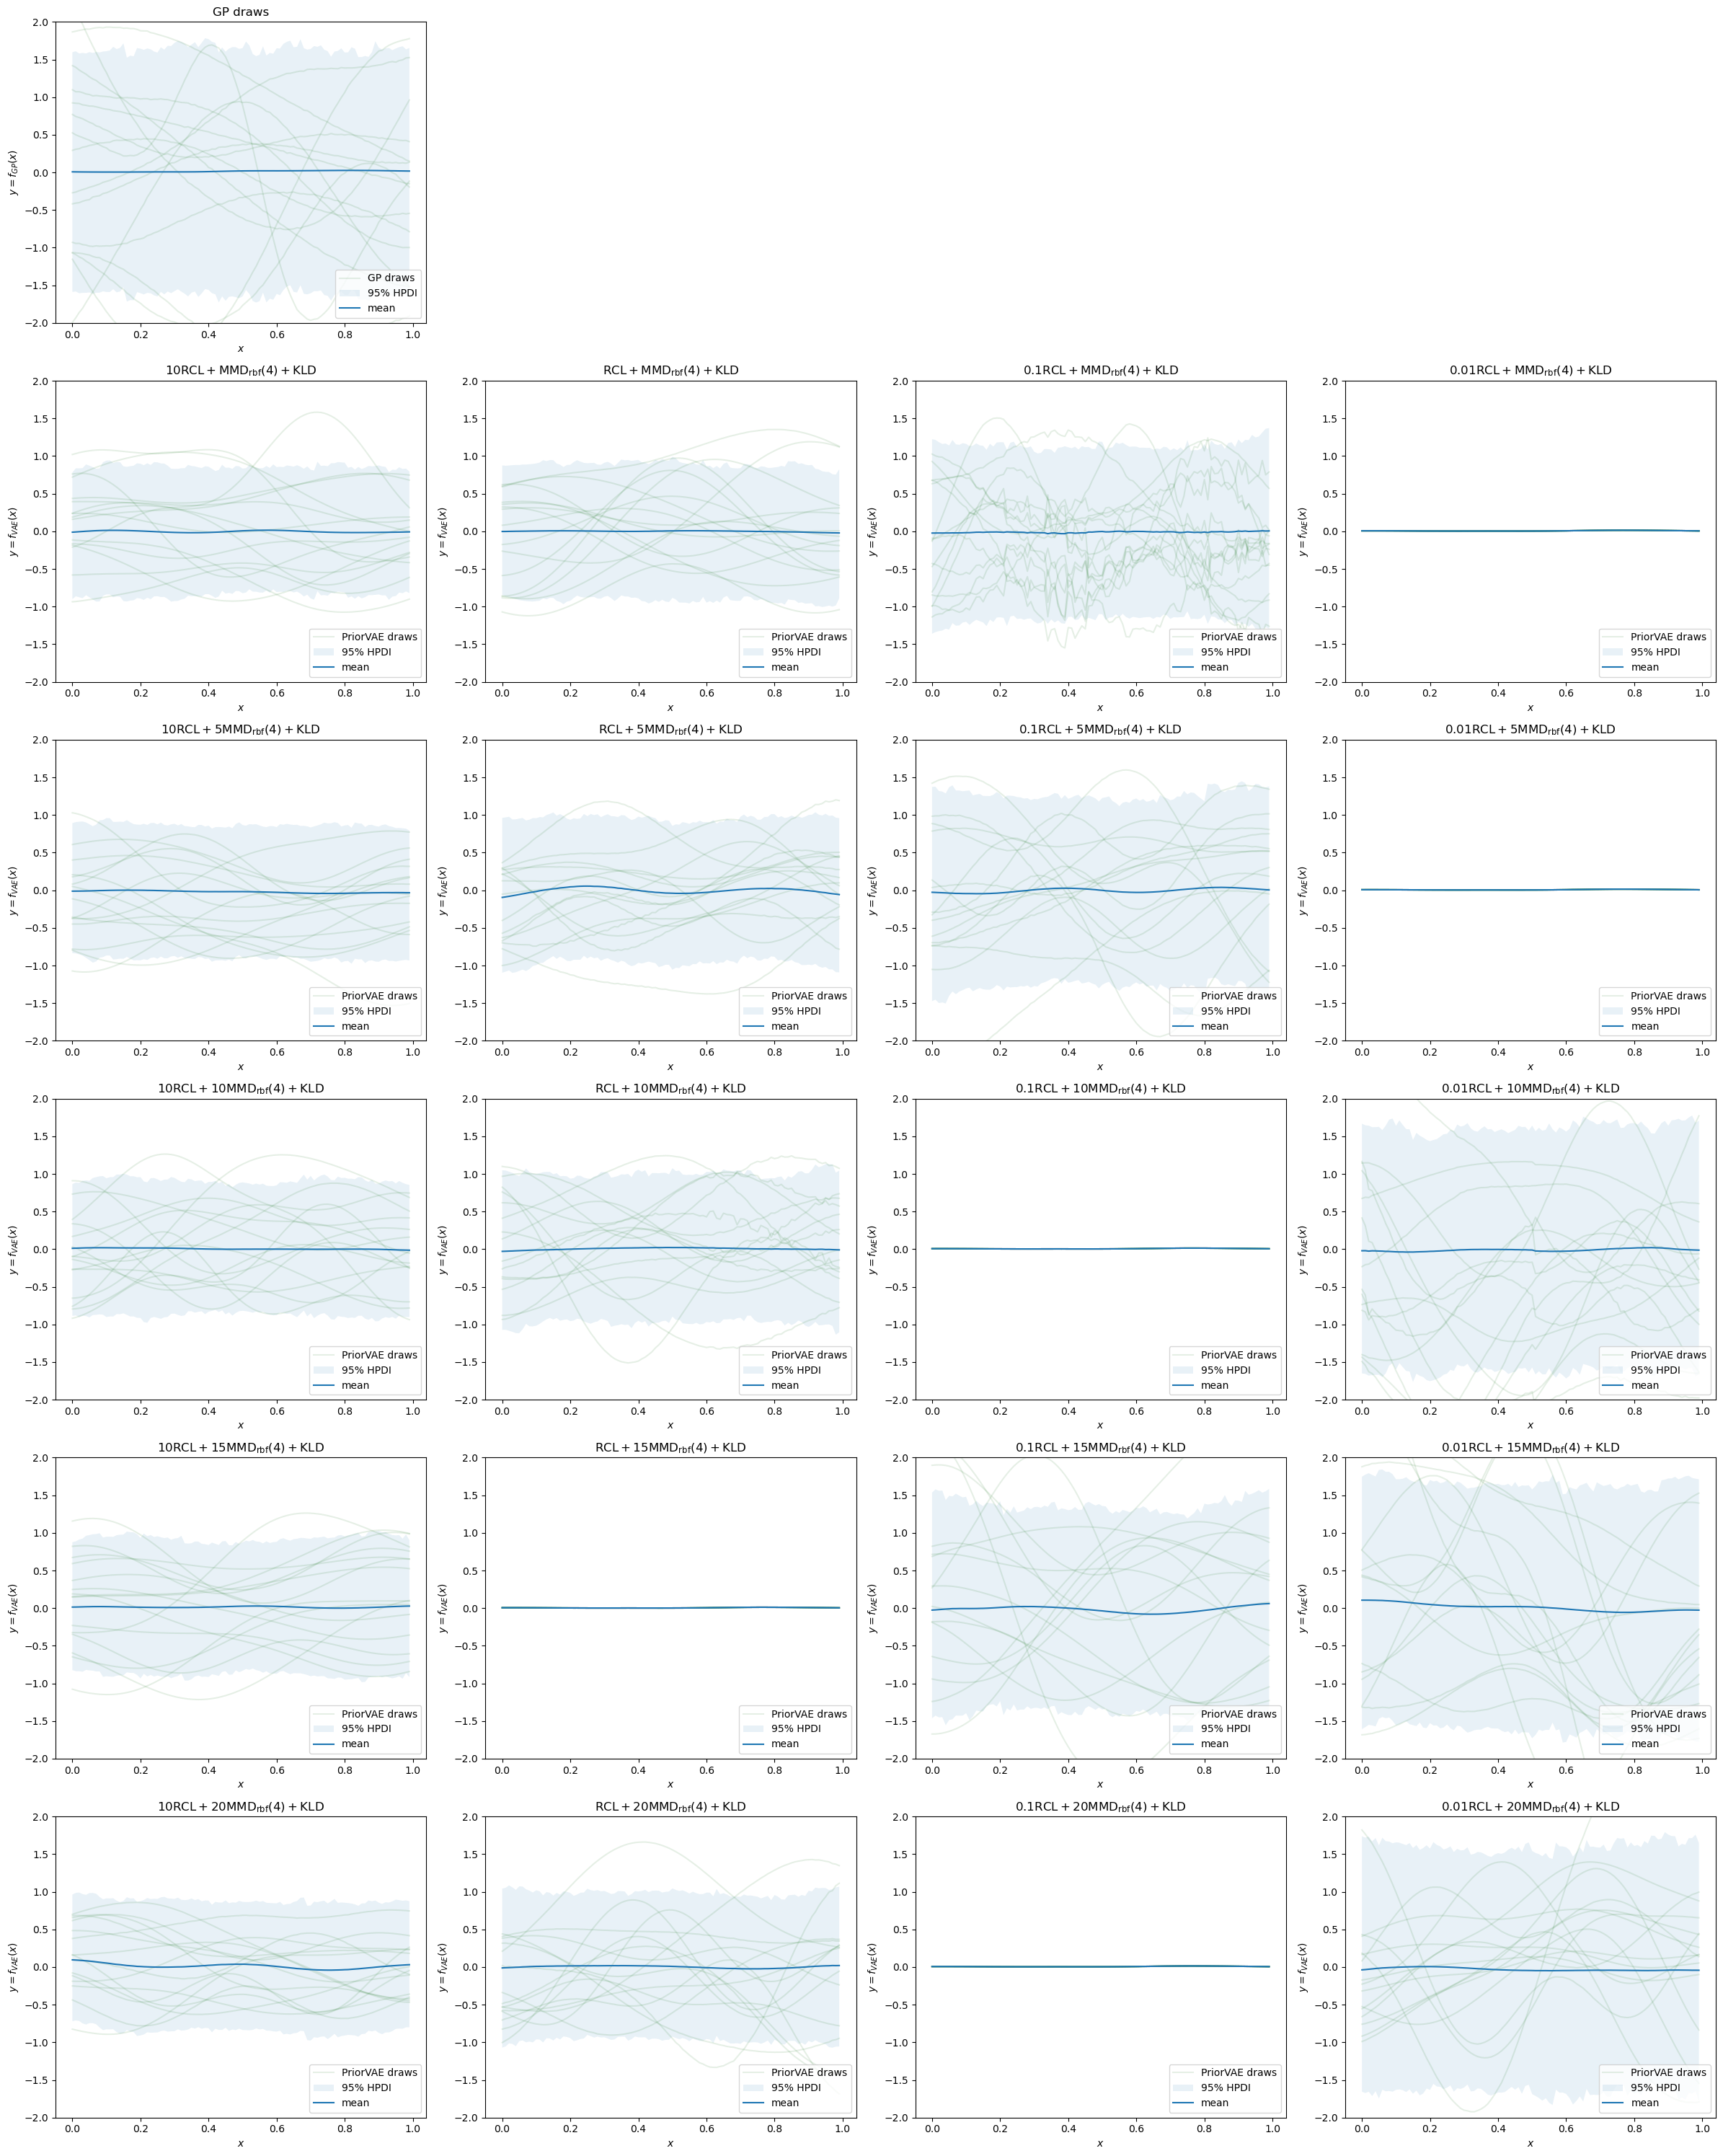

In [7]:
experiment = "exp3"
number = "1" # disambiguate argument files

show_loss_scores(16, experiment, number)
plot_training_histories(16, experiment, number, backfill="align_right")
plot_trained_draws(16, experiment, number,  backfill="align_right")

# 18 - leaky relu try

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


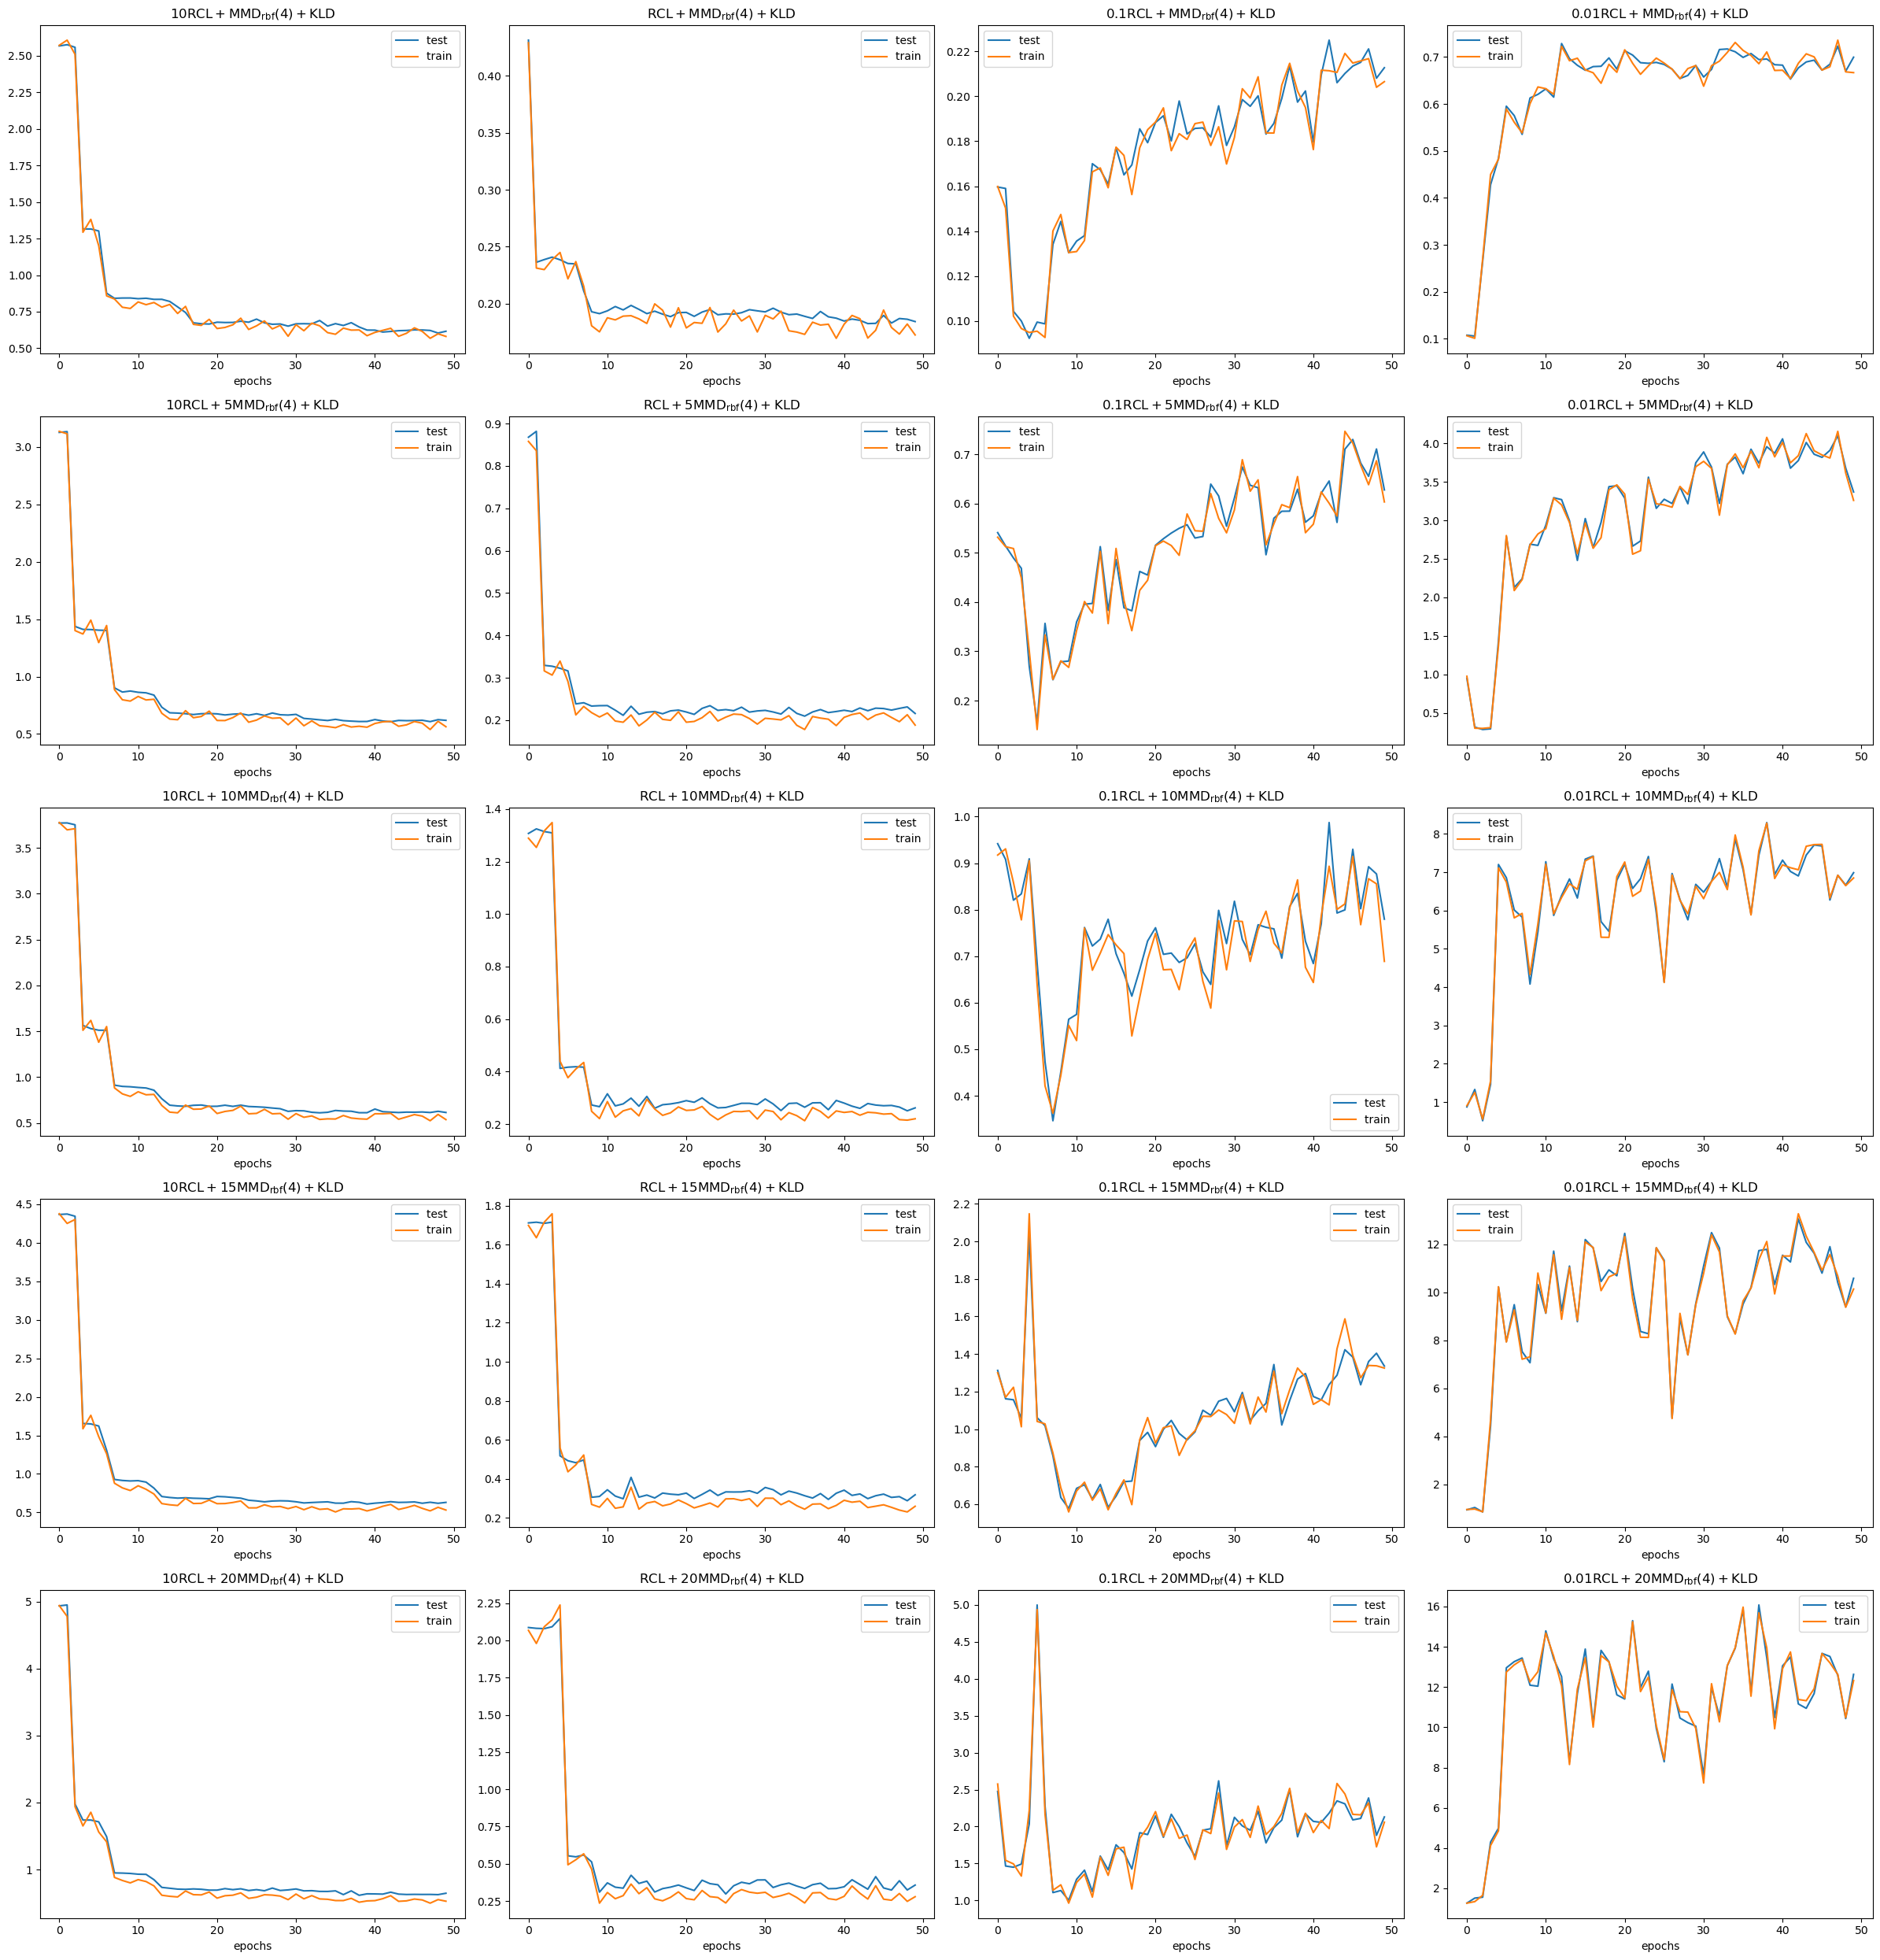

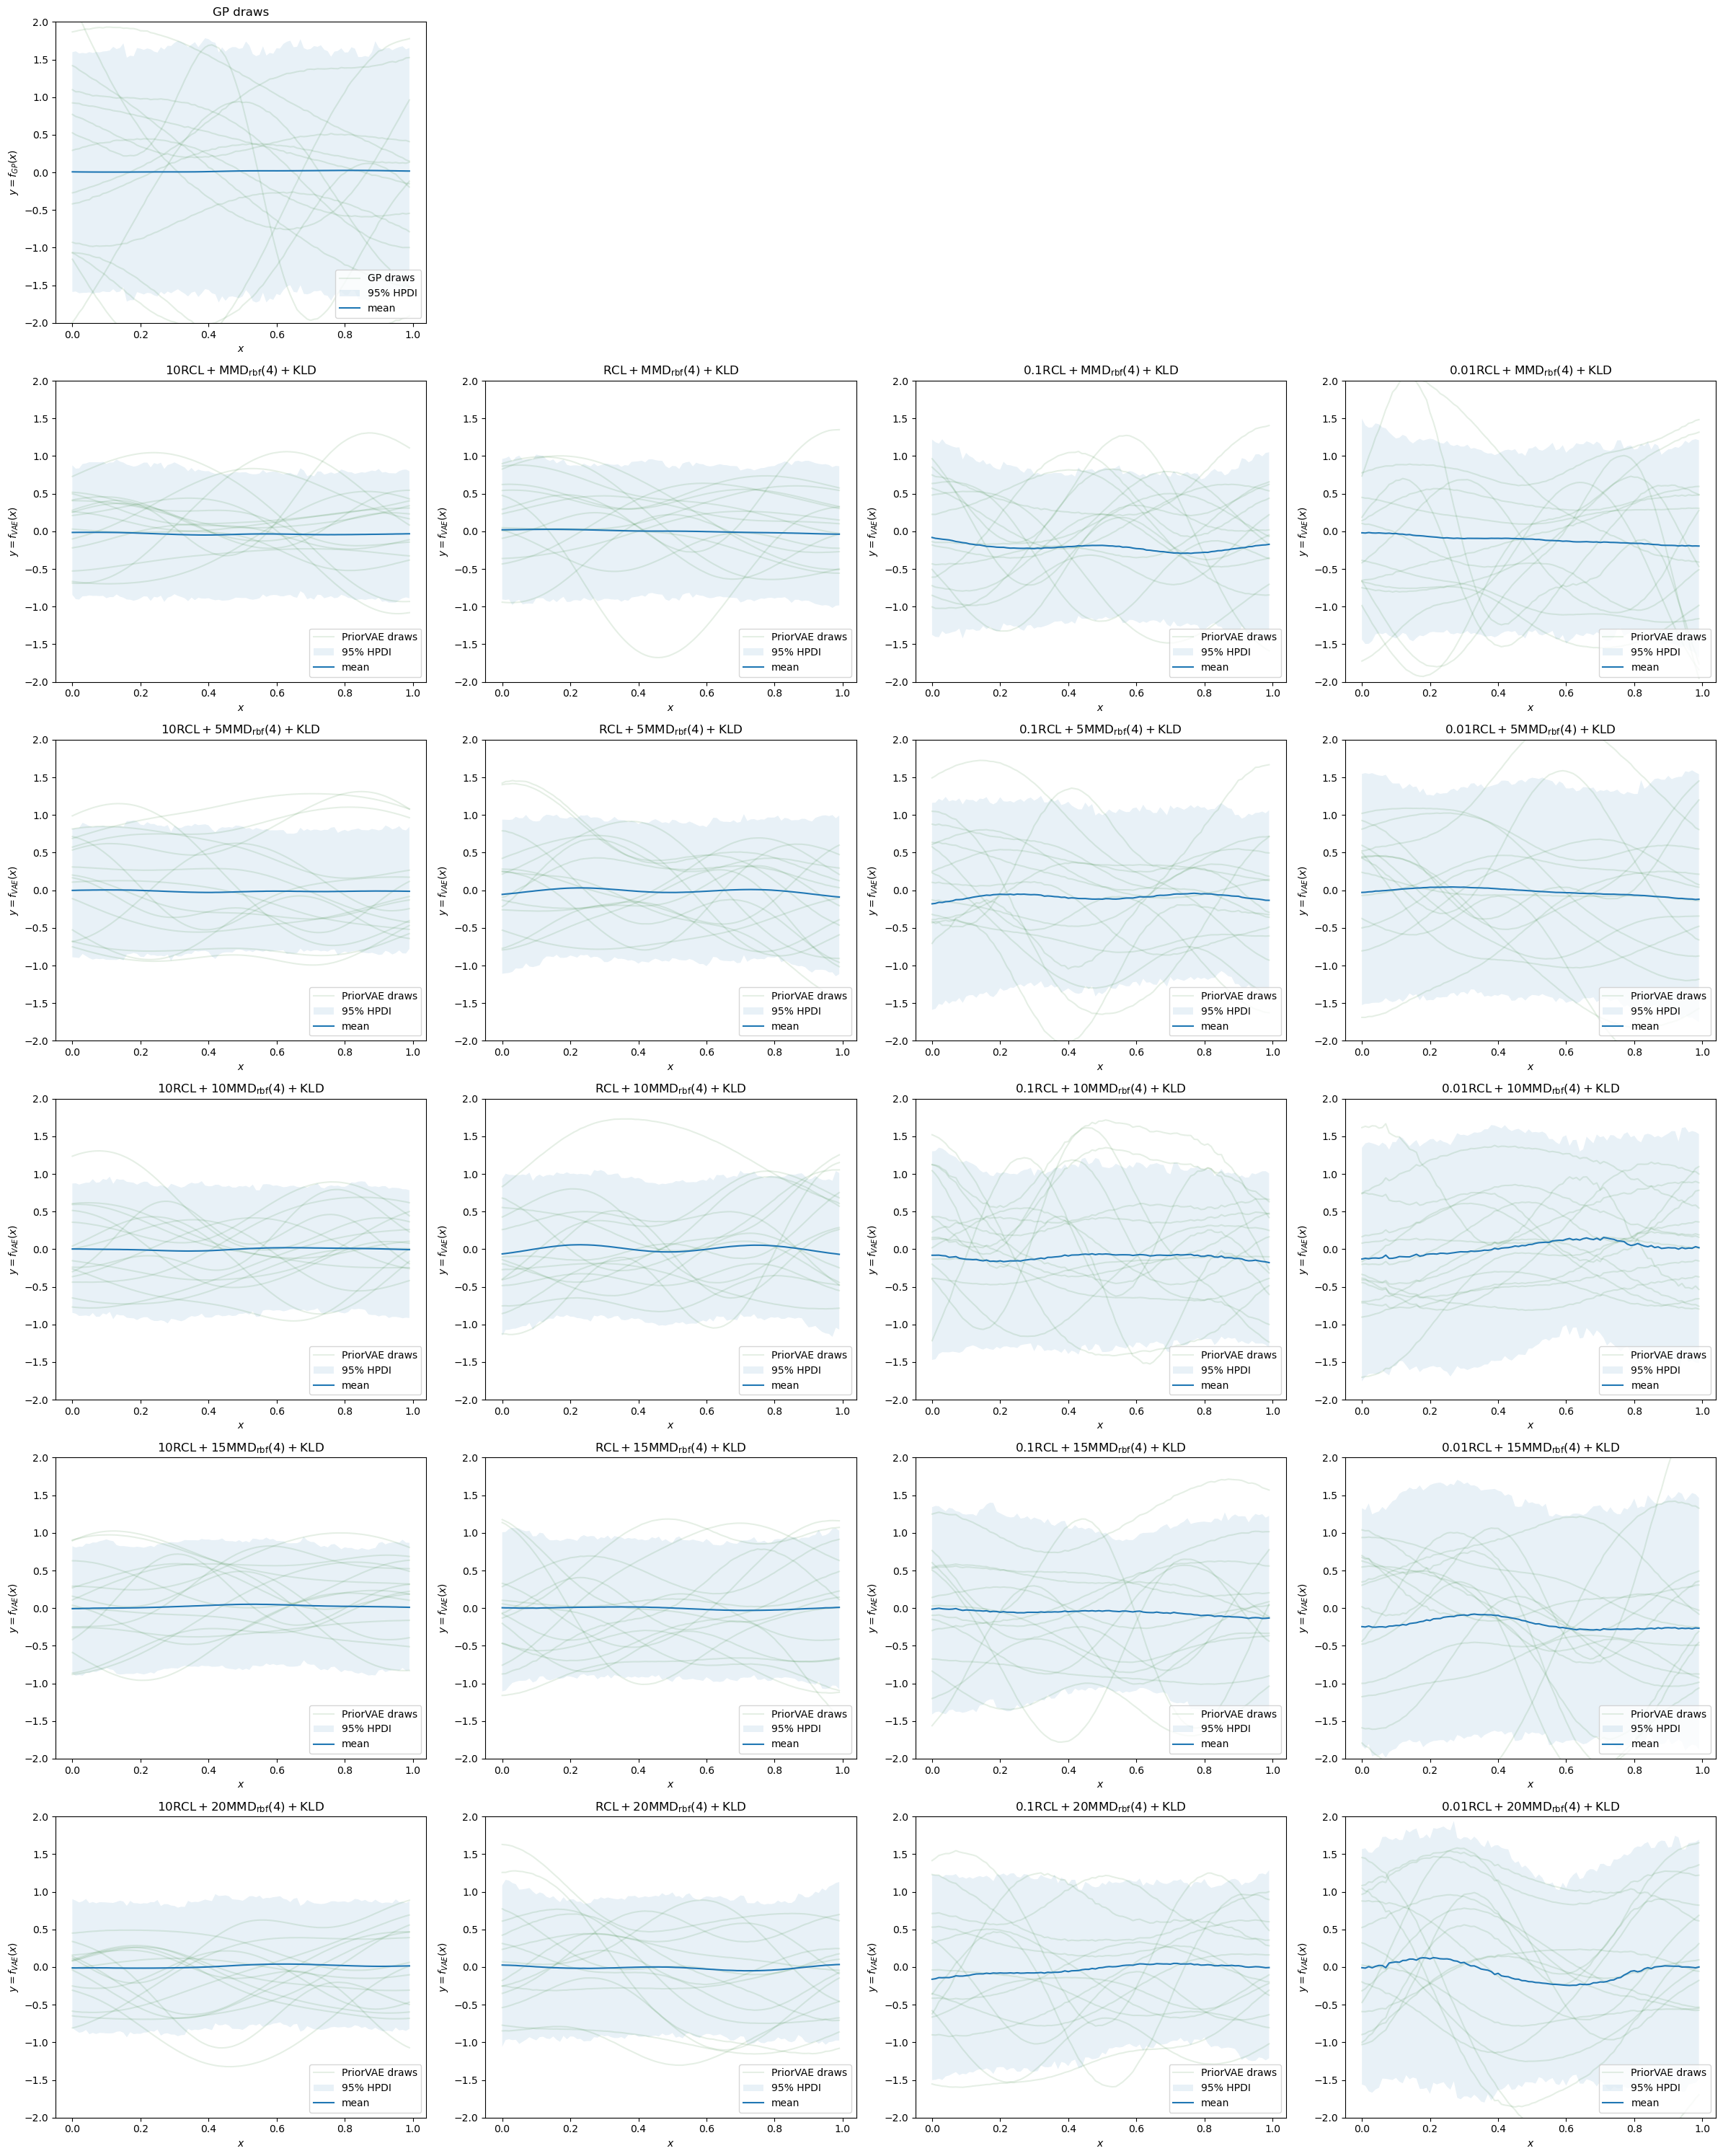

In [6]:
experiment = "exp3"
number = "1" # disambiguate argument files

#show_loss_scores(18, experiment, number)

plot_training_histories(18, experiment, number, backfill="align_right")
plot_trained_draws(18, experiment, number, backfill="align_right")

FrozenDict({
    params: {
        DEC Hidden1: {
            kernel: array([[ 0.00192794,  0.00638258,  0.00059036, ..., -0.01325808,
                     0.00545131,  0.00358527],
                   [-0.01218206, -0.01456962,  0.02827845, ...,  0.02389423,
                    -0.00511799, -0.00235572],
                   [ 0.01331165,  0.00506231,  0.01410355, ...,  0.03922044,
                     0.00334868,  0.00120783],
                   ...,
                   [-0.00940133,  0.01064944,  0.03986111, ..., -0.03171922,
                     0.00692839,  0.01317744],
                   [ 0.00577365, -0.00614617,  0.02729926, ..., -0.01179509,
                    -0.00300244,  0.00320075],
                   [ 0.00461664,  0.01403137,  0.02609558, ...,  0.01756115,
                     0.00647302,  0.00805411]], dtype=float32),
            bias: array([ 0.00410624, -0.03630921,  0.02272761, -0.03154569, -0.04069722,
                   -0.0260584 , -0.00462314, -0.03021261, -0.046075

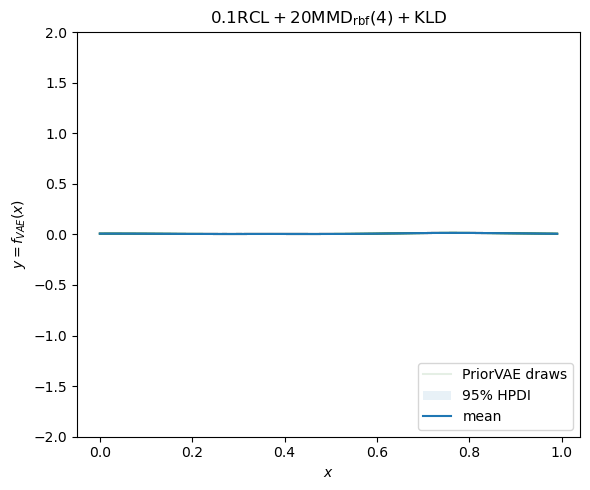

In [19]:
code = 16
args_count = 1
exp_name = "exp3"


rng_key = random.PRNGKey(3)
rng_key, rng_key_gp = random.split(rng_key, 2)

args = load_args(str(code), str(args_count), exp_name)


i = 18
loss_fn = args["loss_fn_names"][i]

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot()


rng_key, rng_key_init, rng_key_predict = random.split(rng_key, 3)

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    conditional=False,
    leaky=False
)
params = module.init(rng_key, jnp.ones((args["n"],)))["params"]
tx = optax.adam(args["learning_rate"])
state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key=rng_key_init)

decoder_params = get_decoder_params(
    load_training_state(code, gen_file_name(code, args, args["experiment"] + loss_fn), state)
    
)

plot_vae_predictive = Predictive(vae_sample, num_samples=5000)
vae_draws = plot_vae_predictive(
    rng_key_predict,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=decoder_params,
)["f"]

plot_draws_hpdi(
    vae_draws,
    args["x"],
    pretty_loss_fn_name(loss_fn),
    "$y=f_{VAE}(x)$",
    "PriorVAE",
    ax=ax,
)

print(decoder_params)

print(vae_draws)

fig.tight_layout()

fig.savefig(f"./gen_plots/{code}/{code}_{exp_name}_{args_count}_{i}_draws.png")


In [18]:
new_state = load_training_state(code, gen_file_name(code, args, args["experiment"] + loss_fn), state)

from reusable.vae import VAE_Decoder

module2 = VAE_Decoder(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    out_dim=args["n"]
)
params = module2.init(rng_key, jnp.ones((args["latent_dim"],)))["params"]


batch = jnp.ones((args["latent_dim"],))

module2.apply(get_decoder_params(new_state), batch)

🤯 [ 0.07619248 -0.09858179  0.06225156  0.02621418 -0.047915   -0.02477325
  0.03513002 -0.16237444 -0.01008689  0.01553582  0.0540571   0.02928539
 -0.04680604 -0.01528359 -0.03743821 -0.06779686 -0.09512409  0.16971533
  0.06731654 -0.08796439 -0.07589416  0.00605725 -0.00072354 -0.03484357
 -0.12719202 -0.02240011 -0.00306297  0.04341772  0.02857461 -0.03473126
 -0.00626433 -0.02669334  0.01829777 -0.04929483 -0.0027386 ] 🤯
🤯 [0.07619248 0.         0.06225156 0.02621418 0.         0.
 0.03513002 0.         0.         0.01553582 0.0540571  0.02928539
 0.         0.         0.         0.         0.         0.16971533
 0.06731654 0.         0.         0.00605725 0.         0.
 0.         0.         0.         0.04341772 0.02857461 0.
 0.         0.         0.01829777 0.         0.        ] 🤯
🤯 [ 1.2551437e-04 -3.9522562e-05  1.4806857e-03  4.1227564e-04
  5.4662931e-04 -2.1580909e-04 -1.3722077e-03  3.9926330e-03
 -1.4608649e-03 -2.1773377e-03 -1.6179802e-03 -4.6402216e-04
  1.1257726e

Array([0.00724615, 0.00726055, 0.00731784, 0.00736474, 0.00738733,
       0.00720841, 0.00711076, 0.00704806, 0.00686414, 0.00684277,
       0.00651964, 0.00637754, 0.00611492, 0.00590481, 0.00562784,
       0.00545952, 0.00522659, 0.0049153 , 0.00476979, 0.00456529,
       0.00447197, 0.00422986, 0.00435422, 0.004075  , 0.00403824,
       0.00390315, 0.00381324, 0.00388399, 0.00377424, 0.0037567 ,
       0.00394144, 0.0038214 , 0.00399225, 0.0040416 , 0.0040331 ,
       0.00406312, 0.00411026, 0.00422528, 0.00409751, 0.00411759,
       0.00399532, 0.00390746, 0.00395182, 0.00388726, 0.0039369 ,
       0.00387608, 0.00377757, 0.00373998, 0.00397638, 0.00397997,
       0.00408805, 0.00429599, 0.00435111, 0.00459218, 0.00482136,
       0.00523478, 0.00559382, 0.00603785, 0.00648771, 0.00687564,
       0.00732784, 0.00800676, 0.00870943, 0.00922487, 0.00971096,
       0.01029342, 0.01088015, 0.01149372, 0.0121333 , 0.01256251,
       0.01295598, 0.0133937 , 0.01385679, 0.0140308 , 0.01434